In [28]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
import sys
import time
from simulation_functions import patients_data, nodes_position, generate_network, addBetweenPathwaysConnection, save_dataset
from simulation_nbs_functions import all_functions
from confusion_matrix import minimal_element_0_to_1, simulated_confusion_matrix
import datetime
from sklearn.model_selection import ParameterGrid
import networkx as nx
import numpy as np
import scipy.sparse as sp
import pickle
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
output_folder = "output/"

pathwaysNum = 10
genesNum = 1000
connProbability = 0.4
connNeighboors = 4
connBetweenPathways = 2

# Simulate patients with a specific mutation profile
patientsNum = 300
mutationProb = 0.2

## Generate simulated data

In [4]:
PPI = generate_network(
    pathwaysNum, genesNum, connNeighboors, connProbability)

for BetweenPathwaysConnection in range(0, pathwaysNum*connBetweenPathways):
    PPI = addBetweenPathwaysConnection(PPI, pathwaysNum, genesNum)

position = nodes_position(PPI, pathwaysNum, genesNum)

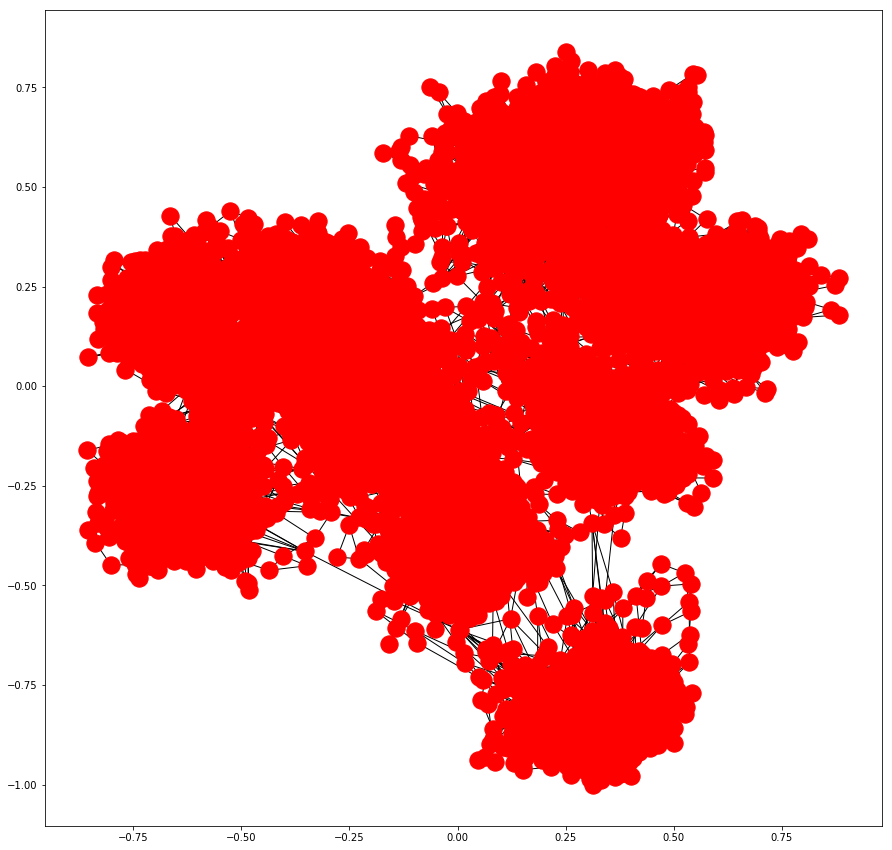

In [5]:
fig = plt.figure(1, figsize=(15, 15))
a=nx.draw_networkx(PPI, with_labels=False)
plt.show()

# Load data & ID mapping

## Load APID PPI data (Dr. Javier DE LAS RIVAS)
Ref: __[APID interactomes: providing proteome-based interactomes with controlled quality for multiple species and derived networks](https://academic.oup.com/nar/article/44/W1/W529/2499348)__<br>

APID server: http://apid.dep.usal.es/<br>
Downloaded on Mon 2018/02(Feb)/05 <br>
Level 2: proven by 2 experiments or more:
- 147 469 interactions
- 17 547 interacting proteins


#### Raw colums:
- InteractionID	
- UniprotID_A	
- UniprotName_A	
- GeneName_A	
- UniprotID_B	
- UniprotName_B	
- GeneName_B	
- Experiments: number of experiments
- Methods: number of methods
- Publications: number of publications
- 3DStructures: number of 3D structures (PDBs)
- CurationEvents: number of curation events (including source databases)



In [260]:
df_apid = pd.read_csv(data_folder + "9606_Q2.txt", sep="\t")
print("interacting proteins number:", df_apid.shape[0])

# keep only interactions between Human-Human proteins
df_apid_HH = df_apid[df_apid.UniprotName_A.str.contains("_HUMAN") & 
                     df_apid.UniprotName_B.str.contains("_HUMAN") == True]
print("interacting Human-Human proteins number:", df_apid_HH.shape[0])

print("{} interspecific interactions removed ({}%)"
      .format(df_apid.shape[0]-df_apid_HH.shape[0],
             round((1-df_apid_HH.shape[0]/df_apid.shape[0])*100,1)))

df_apid_HH.head()

interacting proteins number: 147469
interacting Human-Human proteins number: 129827
17642 interspecific interactions removed (12.0%)


,InteractionID,UniprotID_A,UniprotName_A,GeneName_A,UniprotID_B,UniprotName_B,GeneName_B,Experiments,Methods,Publications,3DStructures,CurationEvents
0,223552,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2L,Q8WWY3,PRP31_HUMAN,PRPF31,3,3,1,0,3
1,273919,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2L,O14964,HGS_HUMAN,HGS,2,2,1,0,2
2,274865,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2L,P0DI81,TPC2A_HUMAN,TRAPPC2,2,2,1,0,2
3,287424,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2L,Q6PEW1,ZCH12_HUMAN,ZCCHC12,2,2,1,0,2
4,288839,A0A024R0Y4,A0A024R0Y4_HUMAN,TADA2L,Q13064,MKRN3_HUMAN,MKRN3,2,2,1,0,2


!!! there are some Gene Symbol not found

In [261]:
# keep only GeneSymbol ID and UniProt ID
# then change column names
df_apid_HH = df_apid_HH[["GeneName_A", "UniprotID_A", "GeneName_B", "UniprotID_B"]]
df_apid_HH.columns = ["GeneSymbol_1", "UniProt_1", "GeneSymbol_2", "UniProt_2"]
df_apid_HH.head()

,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2
0,TADA2L,A0A024R0Y4,PRPF31,Q8WWY3
1,TADA2L,A0A024R0Y4,HGS,O14964
2,TADA2L,A0A024R0Y4,TRAPPC2,P0DI81
3,TADA2L,A0A024R0Y4,ZCCHC12,Q6PEW1
4,TADA2L,A0A024R0Y4,MKRN3,Q13064


## Load UniProt KB data

Complete human gene data set downloaded from __[UniProtKB](ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/)__<br>
"HUMAN_9606_idmapping_selected.tab.gz" (2018/01/31)

#### Raw colums:
1. UniProtKB-AC
2. UniProtKB-ID
3. GeneID (EntrezGene)
4. RefSeq
5. GI
6. PDB
7. GO
8. UniRef100
9. UniRef90
10. UniRef50
11. UniParc
12. PIR
13. NCBI-taxon
14. MIM
15. UniGene
16. PubMed
17. EMBL
18. EMBL-CDS
19. Ensembl
20. Ensembl_TRS
21. Ensembl_PRO
22. Additional PubMed

In [61]:
# only get UniProtKB-AC and GeneID (EntrezGene)
df_unip = pd.read_csv(data_folder + "HUMAN_9606_idmapping_selected.tab", sep="\t",
                      index_col=False, usecols=[0,2], names=["UniProt_AC", "EntrezGene"])

In [62]:
df_unip.head()

,UniProt_AC,EntrezGene
0,P31946,7529
1,P62258,7531
2,Q04917,7533
3,P61981,7532
4,P31947,2810


## Load HGNC data
Complete HGNC dataset downloaded from __[HGNC (HUGO Gene Nomenclature Committee)](https://www.genenames.org/cgi-bin/statistics)__ <br>
"hgnc_complete_set.txt" (2018/02(Feb)/09)

#### Raw colums:
1. hgnc_id	
2. symbol	
3. name	
4. locus_group	
5. locus_type	
6. status	
7. location	
8. location_sortable	
9. alias_symbol	
10. alias_name	
11. prev_symbol	
12. prev_name	
13. gene_family	
14. gene_family_id	
15. date_approved_reserved	
16. date_symbol_changed	
17. date_name_changed	
18. date_modified	
19. entrez_id	
20. ensembl_gene_id	
21. vega_id	
22. ucsc_id	
23. ena	
24. refseq_accession	
25. ccds_id	
26. uniprot_ids	
27. pubmed_id	
28. mgd_id	
29. rgd_id	
30. lsdb	
31. cosmic	
32. omim_id	
33. mirbase	
34. homeodb	
35. snornabase	
36. bioparadigms_slc	
37. orphanet	
38. pseudogene.org	
39. horde_id	
40. merops	
41. imgt	
42. iuphar	
43. kznf_gene_catalog	
44. mamit-trnadb	
45. cd	
46. lncrnadb	
47. enzyme_id	
48. intermediate_filament_db	
49. rna_central_ids


In [327]:
# only get symbol (Gene Symbol), entrez_id (EntrezGene) and uniprot_ids
df_hgnc = pd.read_csv(data_folder + "hgnc_complete_set.txt", sep="\t",
                      index_col=False, usecols=[1,18,25])

In [328]:
df_hgnc.head()

,symbol,entrez_id,uniprot_ids
0,A1BG,1.0,P04217
1,A1BG-AS1,503538.0,NaN
2,A1CF,29974.0,Q9NQ94
3,A2M,2.0,P01023
4,A2M-AS1,144571.0,NaN


## ID mapping: From UniProt ID (UniProtKB-AC) to EntrezGene ID
### Overlapping analysis between UniProt and EntrezGene

In [186]:
# ADIP
apid_unip1 = df_apid_HH.UniProt_1.tolist()
apid_unip2 = df_apid_HH.UniProt_2.tolist()
apid_unip = set(apid_unip1 + apid_unip2)
print("interacting proteins number:", len(apid_unip))

# UniProt dataset
unip_entrez = set(df_unip.UniProt_AC.tolist())
print('all UniProt ID in dataset:', len(unip_entrez))

interacting proteins number: 15044
all UniProt ID in dataset: 161566


In [192]:
# Comparison
intersection_prot = apid_unip.intersection(unip_entrez)
print("number of UnitProt ID found in EntrezGene ID:", len(list(intersection_prot)))
print("{} of APID's UnitProt ID are not found in EntrezGene ID "
      .format(len(apid_unip)-len(intersection_prot)))

# save UnitProt ID not found in EntrezGene ID
# f = open("uniprot_not_found_in_entrezGene.txt", 'w')
# for i in not_found:
#     f.write("%s\n" %i)

number of UnitProt ID found in EntrezGene ID: 15028
16 of APID's UnitProt ID are not found in EntrezGene ID 


### ID mapping

In [346]:
# merge on APID's UniProt 1
joined = pd.merge(df_apid_HH, df_unip, left_on='UniProt_1', right_on='UniProt_AC', how='left')

# merge on APID's UniProt 2
joined2 = pd.merge(joined, df_unip, left_on='UniProt_2', right_on='UniProt_AC', how='left')
joined2.head()

,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,UniProt_AC_x,EntrezGene_x,UniProt_AC_y,EntrezGene_y
0,TADA2L,A0A024R0Y4,PRPF31,Q8WWY3,A0A024R0Y4,6871,Q8WWY3,26121
1,TADA2L,A0A024R0Y4,HGS,O14964,A0A024R0Y4,6871,O14964,9146
2,TADA2L,A0A024R0Y4,TRAPPC2,P0DI81,A0A024R0Y4,6871,P0DI81,6399
3,TADA2L,A0A024R0Y4,ZCCHC12,Q6PEW1,A0A024R0Y4,6871,Q6PEW1,170261
4,TADA2L,A0A024R0Y4,MKRN3,Q13064,A0A024R0Y4,6871,Q13064,7681


In [347]:
# remove UniProt KB ID (redundancy)
df = joined2.drop(['UniProt_AC_x', 'UniProt_AC_y'], axis=1)
df.head()

,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,EntrezGene_x,EntrezGene_y
0,TADA2L,A0A024R0Y4,PRPF31,Q8WWY3,6871,26121
1,TADA2L,A0A024R0Y4,HGS,O14964,6871,9146
2,TADA2L,A0A024R0Y4,TRAPPC2,P0DI81,6871,6399
3,TADA2L,A0A024R0Y4,ZCCHC12,Q6PEW1,6871,170261
4,TADA2L,A0A024R0Y4,MKRN3,Q13064,6871,7681


### Filtering

#### Remove EntrezGene NaN rows
16 of APID's UniProt ID are not found in EntrezGene ID 

In [350]:
df = df[df['EntrezGene_x'].notnull()]
df = df[df['EntrezGene_y'].notnull()]

#### Keep only one EntrezGene ID
One Uniprot ID can give several EntrezGene ID (and thus several Gene Symbol): multigenes<br>
In this case, only one Gene Symbol is kept in APID <br>
So we keep only one EntrezGene ID corresponding to the Gene Symbol

In [357]:
# get data containing several EntrezGene ID
df_multi1 = df[df["EntrezGene_x"].str.contains(';')]
df_multi_unip1 = df_multi1.UniProt_1
df_multi_symbol1 = df_multi1.GeneSymbol_1

df_multi2 = df[df["EntrezGene_y"].str.contains(';')]
df_multi_unip2 = df_multi2.UniProt_2
df_multi_symbol2 = df_multi2.GeneSymbol_2

# prot 1 + prot 2
df_multi_unip = df_multi_unip1.append(df_multi_unip2)
df_multi_symbol = df_multi_unip1.append(df_multi_unip2)

# remove duplicates
df_multi_unip_unique = df_multi_unip.drop_duplicates()
print("There are {} UniProt having several EntrezGene ID (or Gene Symbol)"
      .format(df_multi_unip_unique.shape[0]))

There are 147 UniProt having several EntrezGene ID (or Gene Symbol)


In [378]:
df_multi1.head()

,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,EntrezGene_x,EntrezGene_y
1025,GAGE12E,A1L429,GMCL1,Q96IK5,100132399; 729422; 729428; 729431,64395
1354,TMEM189,A5PLL7,UBE2N,P61088,387521; 387522,7334
1865,FAM25G,B3EWG6,ARMC10,Q8N2F6,100133093; 643161; 644054,83787
1887,CALM1,B4DJ51,CAMTA2,O94983,801; 805; 808,23125
1888,CALM1,B4DJ51,APPBP2,Q92624,801; 805; 808,10513


In [384]:
df_test = df_multi1.iloc[:8,:]
df_test

,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,EntrezGene_x,EntrezGene_y
1025,GAGE12E,A1L429,GMCL1,Q96IK5,100132399; 729422; 729428; 729431,64395
1354,TMEM189,A5PLL7,UBE2N,P61088,387521; 387522,7334
1865,FAM25G,B3EWG6,ARMC10,Q8N2F6,100133093; 643161; 644054,83787
1887,CALM1,B4DJ51,CAMTA2,O94983,801; 805; 808,23125
1888,CALM1,B4DJ51,APPBP2,Q92624,801; 805; 808,10513
3402,EEF2K,O00418,RPS6KA1,Q15418,101930123; 29904,6195
3403,EEF2K,O00418,CDK1,P06493,101930123; 29904,983
3404,EEF2K,O00418,FBXW11,Q9UKB1,101930123; 29904,23291


In [400]:
df_test.loc[:, 'EntrezGene_x']

1025    100132399; 729422; 729428; 729431
1354                       387521; 387522
1865            100133093; 643161; 644054
1887                        801; 805; 808
1888                        801; 805; 808
3402                     101930123; 29904
3403                     101930123; 29904
3404                     101930123; 29904
Name: EntrezGene_x, dtype: object

In [398]:
def one_entrezID_from_symbol(entrez_col, symbol_col):
    return symbol_col

In [402]:
# df_test['out'] = one_entrezID_from_symbol(df_test['EntrezGene_x'], df_test['GeneSymbol_1'])
df_test['out'] = one_entrezID_from_symbol(
    df_test.loc[:, 'EntrezGene_x'], df_test.loc[:, 'GeneSymbol_1'])
df_test

/Users/Min/anaconda/envs/stratipy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,EntrezGene_x,EntrezGene_y,out
1025,GAGE12E,A1L429,GMCL1,Q96IK5,100132399; 729422; 729428; 729431,64395,GAGE12E
1354,TMEM189,A5PLL7,UBE2N,P61088,387521; 387522,7334,TMEM189
1865,FAM25G,B3EWG6,ARMC10,Q8N2F6,100133093; 643161; 644054,83787,FAM25G
1887,CALM1,B4DJ51,CAMTA2,O94983,801; 805; 808,23125,CALM1
1888,CALM1,B4DJ51,APPBP2,Q92624,801; 805; 808,10513,CALM1
3402,EEF2K,O00418,RPS6KA1,Q15418,101930123; 29904,6195,EEF2K
3403,EEF2K,O00418,CDK1,P06493,101930123; 29904,983,EEF2K
3404,EEF2K,O00418,FBXW11,Q9UKB1,101930123; 29904,23291,EEF2K


,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,EntrezGene_x,EntrezGene_y,out
1025,GAGE12E,A1L429,GMCL1,Q96IK5,100132399; 729422; 729428; 729431,64395,None
1354,TMEM189,A5PLL7,UBE2N,P61088,387521; 387522,7334,None
1865,FAM25G,B3EWG6,ARMC10,Q8N2F6,100133093; 643161; 644054,83787,None
1887,CALM1,B4DJ51,CAMTA2,O94983,801; 805; 808,23125,None
1888,CALM1,B4DJ51,APPBP2,Q92624,801; 805; 808,10513,None
3402,EEF2K,O00418,RPS6KA1,Q15418,101930123; 29904,6195,None
3403,EEF2K,O00418,CDK1,P06493,101930123; 29904,983,None
3404,EEF2K,O00418,FBXW11,Q9UKB1,101930123; 29904,23291,None


In [ ]:
df['distance'] = df.apply(lambda row: haversine(40.671, -73.985, row['latitude'], row['longitude']), axis=1)
df['distance'] = haversine(40.671, -73.985,df['latitude'], df['longitude'])
df['distance'] = haversine(40.671, -73.985,df['latitude'].values, df['longitude'].values)


In [364]:
df_multi1 = df[df["EntrezGene_x"].str.contains(';')]
df_multi2 = df[df["EntrezGene_y"].str.contains(';')]
df_multi = df_multi1.append(df_multi2)

df_multi.head()

,GeneSymbol_1,UniProt_1,GeneSymbol_2,UniProt_2,EntrezGene_x,EntrezGene_y
1025,GAGE12E,A1L429,GMCL1,Q96IK5,100132399; 729422; 729428; 729431,64395
1354,TMEM189,A5PLL7,UBE2N,P61088,387521; 387522,7334
1865,FAM25G,B3EWG6,ARMC10,Q8N2F6,100133093; 643161; 644054,83787
1887,CALM1,B4DJ51,CAMTA2,O94983,801; 805; 808,23125
1888,CALM1,B4DJ51,APPBP2,Q92624,801; 805; 808,10513


TypeError: 'tuple' object is not callable

In [ ]:
# rename columns
df = df.rename(index=str, columns={'EntrezGene_x': 'EntrezGene_1',
                                   'EntrezGene_y': 'EntrezGene_2'})

# reorder columns
cols = list(df)
cols.insert(0, cols.pop(cols.index('EntrezGene_x')))
cols.insert(3, cols.pop(cols.index('EntrezGene_y')))
df = df.loc[:, cols]

In [287]:
import datetime
filename = ('input/dataset/apid_ppi_{}.csv'.
            format(datetime.datetime.now().strftime("%Y_%m_%d")))
# df.to_csv(filename, sep='\t')